In [1]:
import sys
sys.path.append("/Users/Tanay/Desktop/CS269I/StableCoinSimulator/PyLOB/")

from random import randint
from numpy.random import normal
from collections import defaultdict, OrderedDict, deque
from simulator.PyLOB import OrderBook
import matplotlib.pyplot as plt
import numpy as np
import time
import json
# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
def biased_coin(prob):
    return int(np.random.random() < prob)

def clamp_bas_price(price):
    # 1 BAS = price ETH
    return np.clip(price, 0, 10.0)

def clamp_bas_qty(qty): 
    # Max order size of $100,000
    return np.clip(qty, 0, 1e5)

def months_to_seconds(mths):
    return mths * 30 * 24 * 60 * 60

In [21]:
# ETH trading settings
ETH_DAY_OFFSET = 0
TRADES_PER_DAY = 15000

# BOND settings
BOND_EXPIRY = months_to_seconds(60)
BOND_DELAY = 20000 # Steps 
BOND_RANGE = (0.99, 1.01)

# MARKET price settings 
BASE_SPREAD = 1e-3 # 0.1% 
PRICE_NOISE = 1e-4
VOL_MA_STEPS = 1000
PRICE_MA_STEPS = 1000
MARKET_SPEED = 0.2

# DEMAND ratio settings
PRICE_SCALE = 1e-3
VAR_SCALE = 0 #1e-3

# TRADER settings
BASIC_TRADER_THRESHOLD = 0.05 # trades when BAS < 0.95 or BAS > 1.05

# TRADER demographics 
trader_demographics = OrderedDict()
trader_demographics['IdealTrader'] = 5
trader_demographics['AverageTrader'] = 500
trader_demographics['BasicTrader'] = 100
trader_demographics['InvestorTrader'] = 5

# SIMULATION SETTINGS 
NUM_ORDERS_INIT = PRICE_MA_STEPS * 3
NUM_ORDERS_LIVE = 100000

# TRACKING settings 
TRACK_FREQ = 50 # Track every 50 steps

# NOTES
'''
    Can do 
        trades, idNum = market.processOrder(order)
    But don't use the return values unless needed for processing
    
    The orderbook is modified. It takes in the traderpool and messes with their balances. 
    Ideally this should be done in the market but its a pain in the butt. 
''' 

In [4]:
class BasisBond: 
    def __init__(self, tid, timestamp, amount, expiry):
        self.tid = tid
        self.timestamp = int(timestamp)
        self.expirytime = self.timestamp + expiry
        self.amount = amount

In [5]:
class Protocol:
    def __init__(self, totalSupply):
        self.totalSupply = totalSupply
        self.market = None
        
    def update(self):
        pass
        
class BasisProtocol(Protocol):
    
    def __init__(self, totalSupply, market):
        super().__init__(totalSupply)
        self.market = market
        self.bond_expiry = BOND_EXPIRY # 5 year expiry
        self.bondsForAuction = 0
        self.bondQueue = deque()
        self.bondQueueLength = 0
        self.delay = BOND_DELAY # In Steps
        self.lastAuction = 0 # Last aucion
        self.currentStep = 0
        
    def issueBonds(self, tid, amount):
        self.bondQueue.append(BasisBond(tid, time.time(), amount, self.bond_expiry))
        self.bondsForAuction -= amount
        self.bondQueueLength += amount
        
        # Basis are burnt outside of this code 
        
    def update(self):
        price = self.market.getCurrentUSDValue()
        self.currentStep += 1
        
        LOWER, UPPER = BOND_RANGE
        
        if self.currentStep < self.lastAuction + self.delay:
            return
        
        # ISSUE bonds
        if price < LOWER:
            
            newSupply = price * self.market.avgVolume
            bondsToCreate = self.market.avgVolume - newSupply 
            self.bondsForAuction += bondsToCreate
            self.lastAuction = self.currentStep
            
        elif price > UPPER:
            newSupply = price * self.market.avgVolume
            basisToCreate = newSupply - self.market.avgVolume
            self.lastAuction = self.currentStep
            
            while len(self.bondQueue) and basisToCreate:
                head = self.bondQueue.popleft()
                if head.amount > basisToCreate:
                    self.market.traderPool[head.tid].liquidate(head.amount)
                    head.amount -= basisToCreate
                    basisToCreate = 0
                    self.bondQueue.appendleft(head)
                    self.bondQueueLength -= basisToCreate
                else:
                    self.market.traderPool[head.tid].liquidate(head.amount)
                    basisToCreate -= head.amount
                    self.bondQueueLength -= head.amount
                    
            if basisToCreate > 0:
                # Distribute to shareholders
                pass
            

In [6]:
class Trader: 
    def __init__(self, tid, protocol, market):
        self.tid = tid
        self.protocol = protocol
        self.market = market
        self.portfolioRatio = 0.5
        self.eth = 10
        self.bas = 1000
        self.bondsLiquidated = 0
        
    def liquidate(self, amount):
        self.bas += amount
        self.bondsLiquidated += amount
        
    def get_price(self, side, base_price):        
        # Set price around BASE_PRICE
        price = normal(base_price, PRICE_NOISE)
        if side == 'bid':
            price -= (base_price * BASE_SPREAD) 
        else:
            price += (base_price * BASE_SPREAD) 
        return clamp_bas_price(price)
        
    def get_qty(self):
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = normal(qty_mu, qty_sigma) * self.bas
        return clamp_bas_qty(qty)
        
    def getIdealValue(self):
        return self.eth * 100 + self.bas

    def marketStep(self):
        return None
    
'''
    IdealTrader buys/sells according to market demand. 
    Sets prices to be around the ideal exchange rate ~ 0.01.
'''
class IdealTrader(Trader):
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.bas = int(1e5) # $100,000 in BASIS 
        self.portfolioRatio = 0.05
        
    def marketStep(self):
        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(0.5)]
        
        # Set Quantity around portfolio ratio 
        qty = self.get_qty()

        if qty <= 0:
            return None
        
        # Set price around BASE_PRICE
        price = self.get_price(side, self.market.usd_eth)
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order
    
class AverageTrader(Trader): 
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.portfolioRatio = 0.05
        self.bas = int(1e4)
        
    def marketStep(self):
        # Set Quantity around portfolio ratio 
        qty = self.get_qty()
        
        if qty <= 0:
            return None
        
        # Randomly select bid / ask based on market demand
        side = ['ask', 'bid'][biased_coin(self.market.demandRatio)]
        
        # Try to see if need for BAS can be satisfied with liquidated bonds
        if side == 'bid' and self.bondsLiquidated:
            if self.bondsLiquidated > qty:
                self.bondsLiquidated -= qty
                return None
            else:
                qty -= self.bondsLiquidated
                self.bondsLiquidated = 0
        
        # If there is high confidence, then buy bonds in the auction.
        if side == 'ask' and biased_coin(self.market.demandRatio) and self.protocol.bondsForAuction:
            # Buy the bonds for a price 
            price = randint(90, 99) * 0.01 # Gets the price the person is willing to pay for the bonds
            qty = min(qty, self.protocol.bondsForAuction)
            qty = min(qty, self.bas / price)
            self.protocol.issueBonds(self.tid, qty)
            burntBasis = price * qty
            self.bas -= burntBasis
            self.protocol.totalSupply -= burntBasis
            return None
        
        # Set price around BASE_PRICE
        price = self.get_price(side, self.market.getIdealETHValue())
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order

    
class InvestorTrader(Trader): 
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.portfolioRatio = 0.001
        self.bas = int(1e7)
        self.eth = 1000
    
class TrendMaker(Trader):
    pass

class BasicTrader(Trader): 
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.portfolioRatio = 0.05
        self.threshold = BASIC_TRADER_THRESHOLD
        self.bas = int(1e4)
        
    def marketStep(self):
        # Set Quantity around portfolio ratio 
        qty = self.get_qty()
        
        if qty <= 0:
            return None
        
        # Randomly select bid / ask based on market demand
        if self.market.getCurrentUSDValue() <= 1.0 - self.threshold:
            side = 'bid'
        elif self.market.getCurrentUSDValue() >= 1.0 + self.threshold:
            side = 'ask'
        else:
            return None
        
        if market.demandRatio < 0.2 and side == 'bid':
            return None
        
        if market.demandRatio > 0.8 and side == 'ask':
            return None
        
        # Set price around BASE_PRICE
        price = self.get_price(side, self.market.getIdealETHValue())
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order

trader_dict = {'IdealTrader': IdealTrader, 'AverageTrader': AverageTrader, 'TrendMaker': TrendMaker, 
               'BasicTrader': BasicTrader, 'InvestorTrader': InvestorTrader}


# Implement TrendMaker, ShareTokens, ShareHolderTrader


In [7]:
def createTraderPool(protocol, market, demographics):
    traderPool = {}
    uniqTID = 1
    for trader_type, number in demographics.items():
        trader_class = trader_dict[trader_type]
        for i in range(number):
            trader = trader_class(uniqTID, protocol, market)
            traderPool[uniqTID] = trader
            uniqTID += 1
    return traderPool

In [8]:
class Market:
    def __init__(self):
        self.demandRatio = 0.5 # in [0, 1]
        
        # ETH Trades
        self.usd_eth = 0.01
        
        self.orderbook = OrderBook(tick_size=0.0001)
        self.traderPool = {}
        
        self.prices = defaultdict(list)
        self.prices['MAday'] = [0]
        self.protocol = None
        self.marketSpeed = MARKET_SPEED
        
        self.askVolume = 0
        self.bidVolume = 0
        self.totalVolume = 0
        self.volMAvel = 1. / VOL_MA_STEPS
        self.circulation = 0
        self.priceMAvel = 1. / PRICE_MA_STEPS
        
    def setTraderPool(self, traderPool):
        self.traderPool = traderPool
        
        if self.protocol:
            basis = 0
            for trader in traderPool.values():
                basis += trader.bas
            self.protocol.totalSupply = basis
        
        self.orderbook.setTraderPool(traderPool)
        
    def getIdealETHValue(self):
        return self.marketSpeed * self.usd_eth + (1 - self.marketSpeed) * self.getCurrentETHValue()
        
    def getCurrentUSDValue(self, func_type='avg_fair'):
        return self.getCurrentETHValue(func_type) / self.usd_eth
        
    ''' Returns the value of BASIS in USD '''
    def getCurrentETHValue(self, func_type='wavg_fair'):
        def avg_bidask():
            return (self.orderbook.getBestBid() + self.orderbook.getBestAsk()) / 2
        
        def wavg_bidask():
            bid_price, ask_price = self.orderbook.getBestBid(), self.orderbook.getBestAsk()
            bid_vol = self.orderbook.getVolumeAtPrice('bid', bid_price)
            ask_vol = self.orderbook.getVolumeAtPrice('ask', ask_price)
            total_vol = bid_vol + ask_vol
            return (bid_price * ask_vol + ask_price * bid_vol) / total_vol
        
        if self.orderbook.getBestBid() is None:
            if self.orderbook.getBestAsk() is not None: 
                return self.orderbook.getBestAsk() # ask, not bid
            else:
                return self.usd_eth # not ask, not bid
        elif self.orderbook.getBestAsk() is None:
            return self.orderbook.getBestBid() # not ask, bid
        
        func_list = {'avg_fair': avg_bidask, 'wavg_fair': wavg_bidask}
        
        return func_list[func_type]()
        
    def setProtocol(self, protocol):
        self.protocol = protocol
        
    def updateDemandRatio(self, factor):
        self.demandRatio *= factor
        self.demandRatio = np.clip(self.demandRatio, 0.1, 1.0)
        
    def getMAprice(self):
        return self.prices['MAday'][-1]
        
    def updateDemand(self):
        # MAprice returns the bas_usd price
        bas_eth = self.getMAprice() * self.usd_eth
        usd_eth = self.usd_eth
        delta = 0
        
        # Demand varies on the price
        if bas_eth < usd_eth and self.demandRatio < 0.8:
            delta = (usd_eth - bas_eth) / usd_eth
            self.updateDemandRatio(1 + delta * PRICE_SCALE)
        elif bas_eth > usd_eth and self.demandRatio > 0.2:   
            delta = (bas_eth - usd_eth) / usd_eth
            self.updateDemandRatio(1 - delta * PRICE_SCALE)
            
        # Demand based on variation
        var = 1e2 * ((usd_eth - bas_eth) / usd_eth) ** 2
        
        if var <= 1e-2 and self.demandRatio < 0.6: # 1 cent 
            self.updateDemandRatio(1 + VAR_SCALE)
        else:
            self.updateDemandRatio(1 - var * VAR_SCALE)
        
    def processOrder(self, quote):
        trades, idNum = self.orderbook.processOrder(quote, False, False)
        
        volumeTraded = sum([trade['qty'] for trade in trades])
        askVolDelta, bidVolDelta = 0, 0
        if quote['bid']:
            askVolDelta += volumeTraded
        if quote['ask']:
            bidVolDelta += volumeTraded
        
        self.circulation += quote['qty']
        self.circulation -= 2 * volumeTraded
        
        self.bidVolume = self.bidVolume * (1 - self.volMAvel) + bidVolDelta * self.volMAvel
        self.askVolume = self.askVolume * (1 - self.volMAvel) + askVolDelta * self.volMAvel
        self.totalVolume = self.bidVolume + self.askVolume
        
        # Calculates and saves the prices
        for func in ['avg_fair', 'wavg_fair']:
            self.prices[func].append(self.getCurrentUSDValue(func))
            
        maPrice = (self.prices['MAday'][-1] * (1 - self.priceMAvel) + 
                   self.getCurrentUSDValue('wavg_fair') * self.priceMAvel)
        
        self.prices['MAday'].append(maPrice)
            
        # Updates the Demand Ratio and Protocol (in case needs to react to price changes)
        self.updateDemand()
            
        if self.protocol is not None:
            self.protocol.update()
            
        return trades, idNum

In [9]:
eth_prices = json.load(open('etherium.json'))

def get_eth_price(t):
    idx = ETH_DAY_OFFSET + (t // TRADES_PER_DAY)
    lin = (t % TRADES_PER_DAY) / (1. * TRADES_PER_DAY)
    if idx >= len(eth_prices) - 1:
        return eth_prices[-1]
    return eth_prices[idx] * (1.0 - lin) + eth_prices[idx + 1] * lin

In [23]:
market = Market()
basis = BasisProtocol(int(1e7), market)
market.protocol = basis
traderPool = createTraderPool(basis, market, trader_demographics)
market.setTraderPool(traderPool)

cur_time = 0
market.usd_eth = 1 / get_eth_price(0)

trackers = {'usd_eth': [], 'bond_q_len': [], 'demand_ratio': [], 'ask_volume': [],
            'bid_volume': [], 'total_volume': []}

def track():
    trackers['usd_eth'].append(market.usd_eth)
    trackers['bond_q_len'].append(protocol.bondQueueLength)
    trackers['demand_ratio'].append(market.demandRatio)
    trackers['ask_volume'].append(market.askVolume)
    trackers['bid_volume'].append(market.bidVolume)
    trackers['total_volume'].append(market.totalVolume)

In [22]:
NUM_TRADERS = trader_demographics['IdealTrader'] # We initially set it up with AverageTraders

for i in range(NUM_ORDERS_INIT):
    market.usd_eth = 1. / get_eth_price(cur_time) 
    
    if i % TRACK_FREQ == 0:
        track()
        
    tid = randint(1, NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order:
        market.processOrder(order)
    cur_time += 1
    
# Keep demandRatio constant at 0.5 when we start the market    
market.demandRatio = 0.5

In [13]:
def bin_data(data, bin_size):
    valid_length = (data.shape[0] // bin_size) * bin_size
    data = data[:valid_length]
    N = data.shape[0]
    binned = np.zeros(N // bin_size)
    for k in range(0, N, bin_size):
        binned[k // bin_size] = data[k : k + bin_size].mean()
    return binned

def plot_prices(market, price_func, bin_size=50, warmup=100, ideal_dev=0.1): 
    data = np.array(market.prices[price_func])[warmup:]
    binned = bin_data(data, bin_size)
    
    ideal = np.ones(binned.shape)
    plt.plot(ideal, 'r')
    plt.plot(ideal - ideal_dev, 'g--')
    plt.plot(ideal + ideal_dev, 'g--')
    plt.plot(binned, 'b')
#     plt.plot(market.prices['MAday'], 'y')
    plt.ylim(1.0 - ideal_dev * 5, 1.0 + ideal_dev * 5)

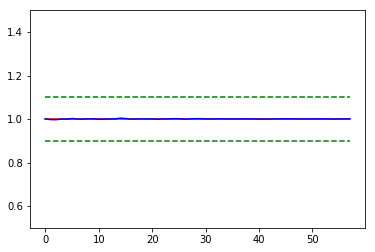

In [14]:
plot_prices(market, 'wavg_fair', warmup=100, ideal_dev=0.1, bin_size=50)

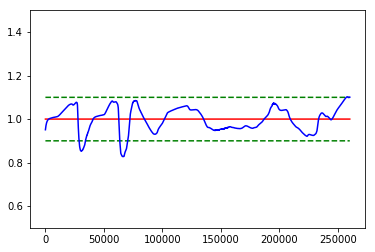

In [15]:
# We initially set it up with AverageTraders
NUM_TRADERS = trader_demographics['AverageTrader'] + trader_demographics['BasicTrader']

OFFSET_TRADERS = trader_demographics['IdealTrader']
for i in range(NUM_ORDERS_LIVE):
    market.usd_eth = 1 / get_eth_price(cur_time) 
    if i % TRACK_FREQ == 0:
        track()
        
    tid = randint(OFFSET_TRADERS + 1, OFFSET_TRADERS + NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order: 
        market.processOrder(order)    
    cur_time += 1
plot_prices(market, 'MAday', bin_size=1, warmup=NUM_ORDERS_INIT)

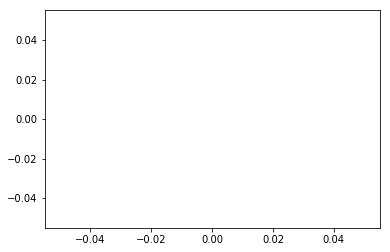

In [26]:
plt.plot(trackers['bond_q_len'], c='b')
# plt.plot(trackers['demand_ratio'], c='r')